In [3]:
# --- Import libraries ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# --- Load the dataset ---
df = pd.read_excel("A:/telcom_data.xlsx")

# --- 1. Check for missing values ---
print("Missing values before cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 Bearer Id                                        0
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  75

In [7]:
# Drop columns with more than 50% missing values as they have too little information to be useful.
threshold = len(df) * 0.5
df_cleaned = df.dropna(axis=1, thresh=threshold)

# OR explicitly drop the two mentioned columns
cols_to_drop = [
    "Nb of sec with 37500B < Vol UL",
    "Nb of sec with 6250B < Vol UL < 37500B"
]

df_cleaned = df_cleaned.drop(columns=cols_to_drop, errors='ignore')

# Display result
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Bearer Id                       150001 non-null  object        
 1   Start                           150000 non-null  datetime64[ns]
 2   Start ms                        150000 non-null  float64       
 3   End                             150000 non-null  datetime64[ns]
 4   End ms                          150000 non-null  float64       
 5   Dur. (ms)                       150000 non-null  float64       
 6   IMSI                            149431 non-null  float64       
 7   MSISDN/Number                   148935 non-null  float64       
 8   IMEI                            149429 non-null  float64       
 9   Last Location Name              148848 non-null  object        
 10  Avg RTT DL (ms)                 122172 non-null  float64

In [9]:
# List of categorical columns to impute
categorical_cols = ["Handset Manufacturer", "Handset Type"]

# Replace missing values with "Unknown"to preserve the rows while explicitly marking the missing information.
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Verify changes
print(df[categorical_cols].isnull().sum())

Handset Manufacturer    0
Handset Type            0
dtype: int64


In [10]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Impute missing values in numerical columns with their median as the median is used because it is less sensitive to outliers than the mean.
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Verify missing values
print(df[numerical_cols].isnull().sum())

Start ms                                    0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)               0
50 Kbps < UL TP < 300 Kbps (%)              0
UL TP > 300 Kbps (%)                        0
HTTP DL (Bytes)                             0
HTTP UL (Bytes)                   

In [12]:
# Impute missing values in Last Location Name 
# This column is categorical/string and was not explicitly targeted in the categorical imputation. It still has 81 missing values.
df["Last Location Name"] = df["Last Location Name"].fillna("Unknown")

# Check remaining missing values
print(df["Last Location Name"].isnull().sum())

# ---- SAVE CLEANED FILE ----
output_path = "cleaned_telecom.xlsx"
df.to_excel(output_path, index=False)

print(f"Cleaned dataset saved as: {output_path}")

0
Cleaned dataset saved as: cleaned_telecom.xlsx


In [13]:
# 1. Identify the top 10 handsets (Handset Type)
top_10_handsets = df['Handset Type'].value_counts().nlargest(10)
print("\n--- 1. Top 10 Handsets ---\n", top_10_handsets)

# 2. Identify the top 3 handset manufacturers (Handset Manufacturer)
top_3_manufacturers = df['Handset Manufacturer'].value_counts().nlargest(3)
top_manufacturers_list = top_3_manufacturers.index.tolist()

# Exclude 'Unknown' if it somehow made the top 3 to focus on known brands
if 'Unknown' in top_manufacturers_list:
    top_manufacturers_list.remove('Unknown')

print("\n--- 2. Top 3 Handset Manufacturers ---\n", top_3_manufacturers.drop(labels=['Unknown'], errors='ignore'))


# 3. Identify the top 5 handsets per top 3 handset manufacturer
top_5_handsets_per_manufacturer = {}

print("\n--- 3. Top 5 Handsets per Top 3 Handset Manufacturer ---")
for manufacturer in top_manufacturers_list:
    # Filter by current manufacturer
    df_manuf = df[df['Handset Manufacturer'] == manufacturer]

    # Get the top 5 Handset Types for this manufacturer
    top_handsets = df_manuf['Handset Type'].value_counts().nlargest(5)
    top_5_handsets_per_manufacturer[manufacturer] = top_handsets

    print(f"\nTop 5 Handsets for {manufacturer}:")
    print(top_handsets)
# The analysis shows that user activity is dominated by a small group of popular handsets and a few major manufacturers. 
# The top 3 manufacturers account for most devices in use, and each one has a handful of highly preferred models. This indicates strong brand loyalty and consistent device preferences among customers.
# Marketing should focus on:
# Running targeted upgrade campaigns for users with older or less popular phones
# Partnering with the top manufacturers for co-branded promotions and device bundles
# Offering data plans tailored to the capabilities of high-end and mid-range devices
# Using handset data to improve customer segmentation and personalization


--- 1. Top 10 Handsets ---
 Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64

--- 2. Top 3 Handset Manufacturers ---
 Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64

--- 3. Top 5 Handsets per Top 3 Handset Manufacturer ---

Top 5 Handsets for Apple:
Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64

Top 5 Handsets for Samsung:
Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galax

In [23]:
# 1. Inspect MSISDN/Number (User ID) for missing values and drop them
df_cleaned_user = df.dropna(subset=['MSISDN/Number']).copy()

# Define the aggregation dictionary
agg_dict = {
    'Bearer Id': 'count',  # Number of xDR sessions
    'Dur. (ms)': 'sum',    # Total session duration
    'Total DL (Bytes)': 'sum', # Total Download Data
    'Total UL (Bytes)': 'sum', # Total Upload Data
    
    # DL and UL components for applications
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum',
}

# 2. Perform the aggregation per user (MSISDN/Number)
user_aggregate = df_cleaned_user.groupby('MSISDN/Number').agg(agg_dict)

# Rename the count and duration columns
user_aggregate = user_aggregate.rename(columns={
    'Bearer Id': 'Number of xDR Sessions',
    'Dur. (ms)': 'Total Session Duration (ms)'
})


# 3. Calculate the total data volume for each application (DL + UL)
app_cols = [
    ('Social Media', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)'),
    ('Google', 'Google DL (Bytes)', 'Google UL (Bytes)'),
    ('Email', 'Email DL (Bytes)', 'Email UL (Bytes)'),
    ('Youtube', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)'),
    ('Netflix', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)'),
    ('Gaming', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)'),
    ('Other', 'Other DL (Bytes)', 'Other UL (Bytes)'),
]

for app_name, dl_col, ul_col in app_cols:
    new_col_name = f'Total {app_name} Data (Bytes)'
    user_aggregate[new_col_name] = user_aggregate[dl_col] + user_aggregate[ul_col]

# Drop the intermediate DL/UL columns for applications
cols_to_drop = [col for _, dl_col, ul_col in app_cols for col in [dl_col, ul_col]]
user_aggregate = user_aggregate.drop(columns=cols_to_drop)

# Reset index to make MSISDN/Number a column again
user_aggregate = user_aggregate.reset_index()

# Save the aggregated data to a CSV file
user_aggregate.to_csv("user_aggregated_metrics.csv", index=False)

In [22]:
# Load the aggregated user data
df_user = pd.read_csv("user_aggregated_metrics.csv")

# Define the aggregation dictionary for the application columns
app_cols_total = [
    'Total Social Media Data (Bytes)',
    'Total Google Data (Bytes)',
    'Total Email Data (Bytes)',
    'Total Youtube Data (Bytes)',
    'Total Netflix Data (Bytes)',
    'Total Gaming Data (Bytes)',
    'Total Other Data (Bytes)'
]

# Calculate the total traffic (DL + UL) for all sessions for each user
df_user['Total Traffic (Bytes)'] = df_user['Total DL (Bytes)'] + df_user['Total UL (Bytes)']

# Calculate the total application traffic for each user
df_user['Total App Traffic (Bytes)'] = df_user[app_cols_total].sum(axis=1)

# Check the ratio of Total App Traffic to Total Traffic
df_user['App Traffic Ratio'] = df_user['Total App Traffic (Bytes)'] / df_user['Total Traffic (Bytes)']

# --- 1. Find the Top 10 Most Engaged Users by Total Traffic ---
top_10_traffic_users = df_user.sort_values(by='Total Traffic (Bytes)', ascending=False).head(10)
print("\n--- 1. Top 10 Most Engaged Users by Total Traffic (Bytes) ---")
print(top_10_traffic_users[['MSISDN/Number', 'Total Traffic (Bytes)', 'Number of xDR Sessions']])

# --- 2. Find the Top 10 Most Engaged Users by Sessions ---
top_10_session_users = df_user.sort_values(by='Number of xDR Sessions', ascending=False).head(10)
print("\n--- 2. Top 10 Most Engaged Users by Number of xDR Sessions ---")
print(top_10_session_users[['MSISDN/Number', 'Total Traffic (Bytes)', 'Number of xDR Sessions']])

# Save the updated DataFrame
df_user.to_csv("user_aggregated_metrics_with_totals.csv", index=False)


--- 1. Top 10 Most Engaged Users by Total Traffic (Bytes) ---
       MSISDN/Number  Total Traffic (Bytes)  Number of xDR Sessions
53644   3.366371e+10           5.319636e+11                    1067
6437    3.361489e+10           8.846226e+09                      17
92923   3.376054e+10           8.514774e+09                      15
13180   3.362578e+10           8.499621e+09                      17
13526   3.362632e+10           7.971167e+09                      18
76363   3.367588e+10           7.891111e+09                      15
37052   3.365973e+10           7.705863e+09                      16
63028   3.366646e+10           7.308501e+09                      11
92577   3.376041e+10           7.132371e+09                      12
57241   3.366471e+10           6.872018e+09                      11

--- 2. Top 10 Most Engaged Users by Number of xDR Sessions ---
       MSISDN/Number  Total Traffic (Bytes)  Number of xDR Sessions
53644   3.366371e+10           5.319636e+11              

In [45]:
import pandas as pd

# Load the aggregated user data (assuming this file contains separate DL and UL app data)
df_user = pd.read_csv("user_aggregated_metrics.csv")

# Identify the application columns that need to be summed (DL and UL components)
app_cols = [
    ('Social Media', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)'),
    ('Google', 'Google DL (Bytes)', 'Google UL (Bytes)'),
    ('Email', 'Email DL (Bytes)', 'Email UL (Bytes)'),
    ('Youtube', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)'),
    ('Netflix', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)'),
    ('Gaming', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)'),
    ('Other', 'Other DL (Bytes)', 'Other UL (Bytes)'),
]

# Create new columns for the total data volume for each application (DL + UL)
for app_name, dl_col, ul_col in app_cols:
    new_col_name = f'Total {app_name} Data (Bytes)'
    # Sum the DL and UL traffic for the current application
    if dl_col in df_user.columns and ul_col in df_user.columns:
        df_user[new_col_name] = df_user[dl_col] + df_user[ul_col]

# Drop the intermediate DL/UL columns for applications (optional, but cleans the final output)
cols_to_drop = [col for _, dl_col, ul_col in app_cols for col in [dl_col, ul_col] if col in df_user.columns]
df_user_final = df_user.drop(columns=cols_to_drop)

# Save the updated DataFrame
df_user_final.to_csv("user_aggregated_metrics_app_totals.csv", index=False)
df_app_totals = pd.read_csv("user_aggregated_metrics_app_totals.csv")
print(df_app_totals.head())
print(df_app_totals.info())


   MSISDN/Number  Number of xDR Sessions  Total Session Duration (ms)  \
0   3.360100e+10                       1                     116720.0   
1   3.360100e+10                       1                     181230.0   
2   3.360100e+10                       1                     134969.0   
3   3.360101e+10                       1                      49878.0   
4   3.360101e+10                       2                      37104.0   

   Total DL (Bytes)  Total UL (Bytes)  Total Social Media Data (Bytes)  \
0      8.426375e+08        36053108.0                        2232135.0   
1      1.207552e+08        36104459.0                        2660565.0   
2      5.566597e+08        39306820.0                        3195623.0   
3      4.019932e+08        20327526.0                         280294.0   
4      1.363130e+09        94280527.0                        2912542.0   

   Total Google Data (Bytes)  Total Email Data (Bytes)  \
0                  4389005.0                 1331362.0   


In [44]:
# CREATE TOTAL TRAFFIC COLUMN
df = pd.read_csv("user_aggregated_metrics_with_totals.csv")  
# 1.Assume columns for data usage (modify if column names differ)
traffic_columns = ["Total DL (Bytes)", "Total UL (Bytes)"]

df["Total Traffic"] = df[traffic_columns].sum(axis=1)


# 2. OUTLIER TREATMENT (Replace Outliers with Mean)

def treat_outliers_with_mean(column):
    """Replace outliers using IQR method with mean value."""
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    mean_val = column.mean()

    # Replace outliers with mean
    return column.apply(lambda x: mean_val if (x < lower or x > upper) else x)

# Apply to all numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    df[col] = treat_outliers_with_mean(df[col])


# 3. SAVE CLEANED FILE
df.to_csv("user_aggregated_metrics_treated.csv", index=False)
df_treated = pd.read_csv("user_aggregated_metrics_treated.csv")
print(df_treated.head())
print(df_treated.info())
print("File saved as user_aggregated_metrics_treated.csv")

   MSISDN/Number  Number of xDR Sessions  Total Session Duration (ms)  \
0   4.511474e+10                     1.0                     116720.0   
1   4.511474e+10                     1.0                     181230.0   
2   4.511474e+10                     1.0                     134969.0   
3   4.511474e+10                     1.0                      49878.0   
4   4.511474e+10                     2.0                      37104.0   

   Total DL (Bytes)  Total UL (Bytes)  Total Social Media Data (Bytes)  \
0      8.426375e+08        36053108.0                        2232135.0   
1      1.207552e+08        36104459.0                        2660565.0   
2      5.566597e+08        39306820.0                        3195623.0   
3      4.019932e+08        20327526.0                         280294.0   
4      1.363130e+09        94280527.0                        2912542.0   

   Total Google Data (Bytes)  Total Email Data (Bytes)  \
0                  4389005.0                 1331362.0   


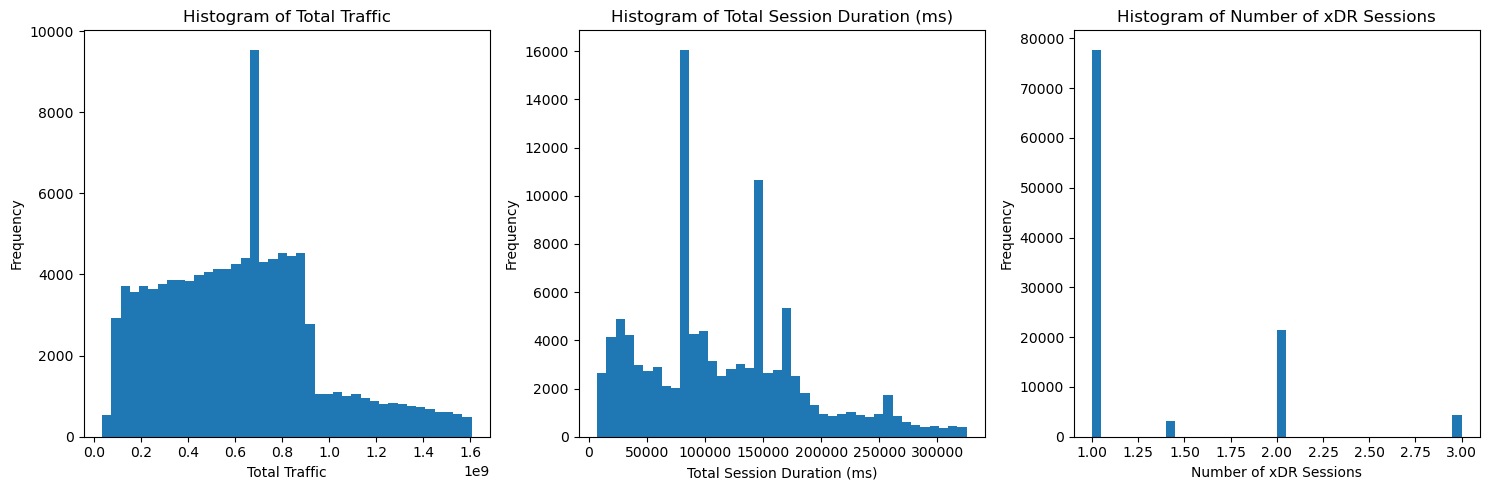

Saved univariate_histograms.png


<Figure size 640x480 with 0 Axes>

In [39]:
# (Target variables: Total Traffic, Total Session Duration, Number of xDR Sessions)
plt.figure(figsize=(15, 5))

columns = ["Total Traffic", "Total Session Duration (ms)", "Number of xDR Sessions"]

for i, col in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=40)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.savefig("univariate_histograms.png", dpi=300)
print("Saved univariate_histograms.png")

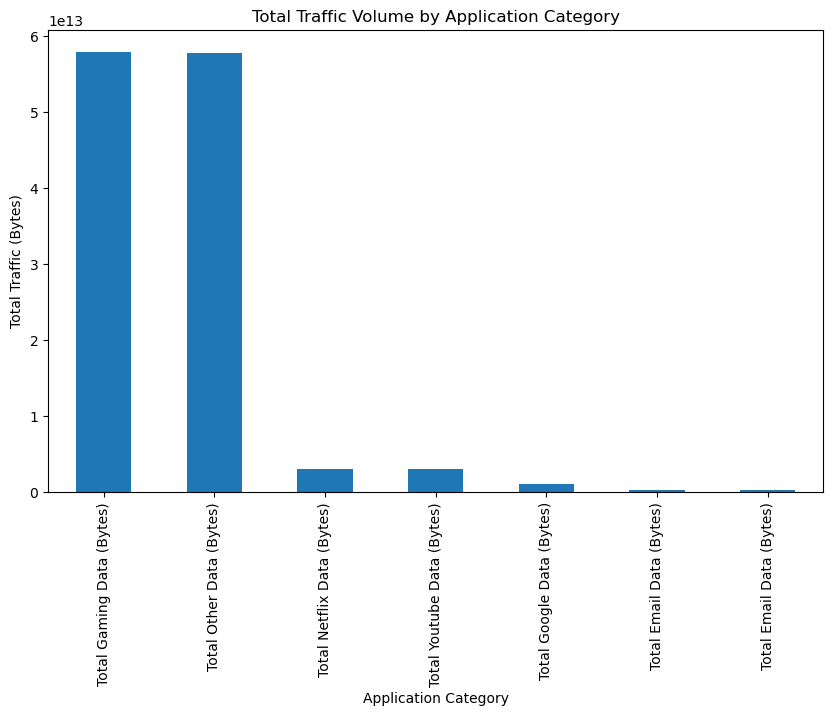

Saved app_traffic_bar_chart.png


In [64]:
# (Sums traffic across application categories)
# List of traffic columns for applications (Example: modify if different)
app_cols = [
    "Total Email Data (Bytes)",
    "Total Google Data (Bytes)",
    "Total Email Data (Bytes)",
    "Total Youtube Data (Bytes)",
    "Total Netflix Data (Bytes)",
    "Total Gaming Data (Bytes)",
    "Total Other Data (Bytes)" 
]

app_traffic_sum = df[app_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
app_traffic_sum.plot(kind="bar")
plt.title("Total Traffic Volume by Application Category")
plt.ylabel("Total Traffic (Bytes)")
plt.xlabel("Application Category")
plt.show()
plt.tight_layout()
plt.savefig("app_traffic_bar_chart.png", dpi=300)
plt.close()
print("Saved app_traffic_bar_chart.png")


In [54]:
# Create duration deciles
# (Based on Total Duration deciles)
df["Duration Decile"] = pd.qcut(df["Total Session Duration (ms)"], 10, labels=False)
# Compute summary total traffic per decile
decile_summary = df.groupby("Duration Decile")["Total Traffic"].sum().reset_index()

# Save results
decile_summary.to_csv("decile_traffic_summary.csv", index=False)

print("Saved decile_traffic_summary.csv")
df_decile_traffic = pd.read_csv("decile_traffic_summary.csv")
print(df_decile_traffic.head())
print(df_decile_traffic.info())

Saved decile_traffic_summary.csv
   Duration Decile  Total Traffic
0                0   5.433343e+12
1                1   6.038859e+12
2                2   6.436400e+12
3                3   6.031816e+12
4                4   5.083147e+12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Duration Decile  10 non-null     int64  
 1   Total Traffic    10 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 292.0 bytes
None


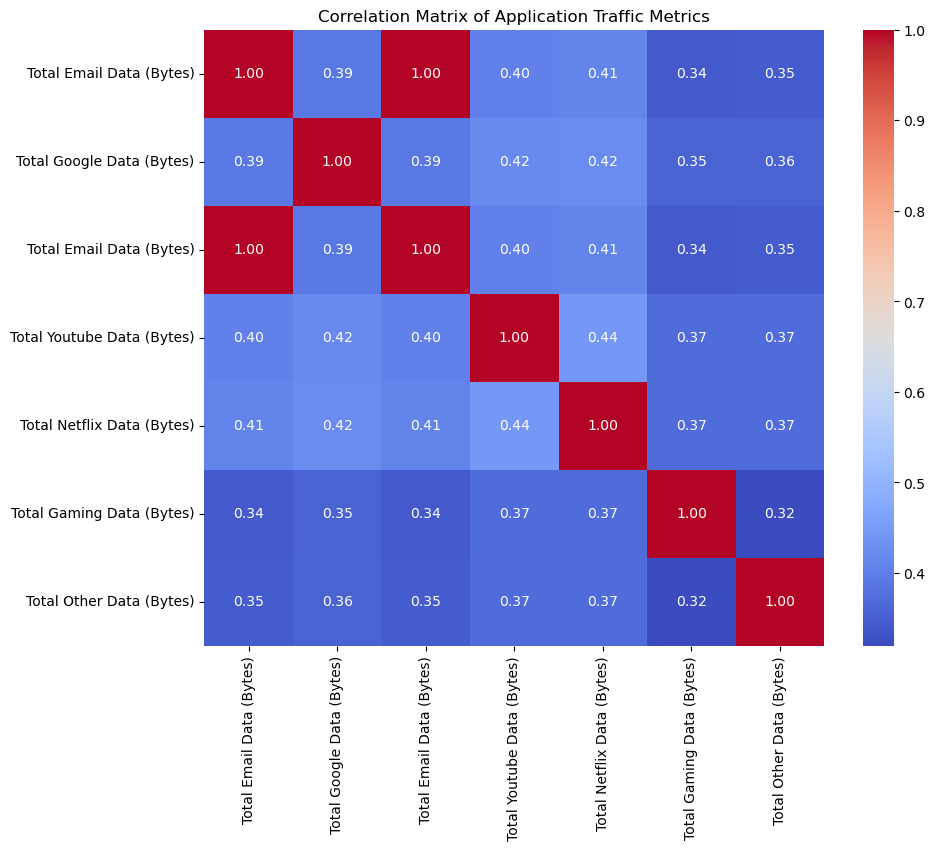

Saved app_correlation_matrix.png


In [66]:
# APPLICATION CORRELATION MATRIX (HEATMAP)
plt.figure(figsize=(10, 8))

corr_matrix = df[app_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Application Traffic Metrics")
plt.show()
plt.tight_layout()
plt.savefig("app_correlation_matrix.png", dpi=300)
plt.close()

print("Saved app_correlation_matrix.png")


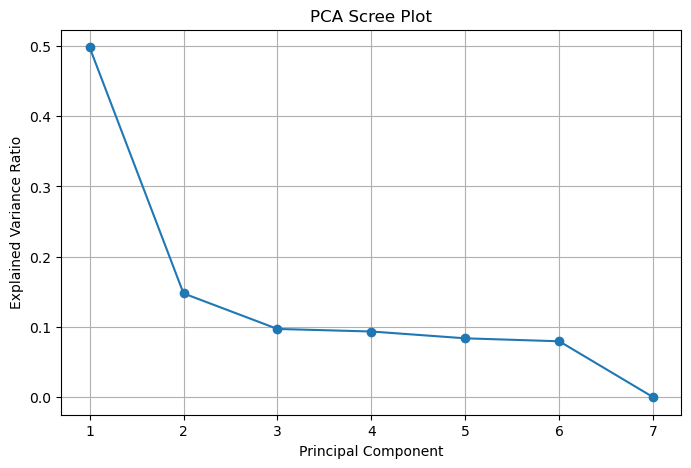

Saved pca_scree_plot.png


In [68]:
# Standardize the data
# (On the 7 application traffic metrics)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[app_cols])

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

expl_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(expl_var) + 1), expl_var, marker='o')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.grid(True)
plt.show()
plt.tight_layout()
plt.savefig("pca_scree_plot.png", dpi=300)
plt.close()

print("Saved pca_scree_plot.png")


In [69]:
# Converting total trafic from byte to GB for better understanding
if 'Total Traffic (Bytes)' not in df.columns:
    df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Convert Total Traffic (Bytes) to Total Traffic (GB) (Using 1024^3 for GiB)
df['Total Traffic (GB)'] = df['Total Traffic (Bytes)'] / (1024 ** 3)

# Display the head of the DataFrame showing the conversion
print(df[['MSISDN/Number', 'Total Traffic (Bytes)', 'Total Traffic (GB)']].head())

# Save the DataFrame with the new GB column
df.to_csv("user_aggregated_metrics_with_GB.csv", index=False)

   MSISDN/Number  Total Traffic (Bytes)  Total Traffic (GB)
0   4.511474e+10           8.786906e+08            0.818344
1   4.511474e+10           1.568596e+08            0.146087
2   4.511474e+10           5.959665e+08            0.555037
3   4.511474e+10           4.223207e+08            0.393317
4   4.511474e+10           1.457411e+09            1.357320


In [70]:
# Track the user’s engagement using the following 
# engagement metrics:  ● sessions frequency  ● the duration of the session  ● the session total traffic (download and upload (GB))
# Ensure 'Total Traffic (Bytes)' is available (calculated in previous EDA steps)
if 'Total Traffic (Bytes)' not in df.columns:
    df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Define the engagement metrics columns
engagement_cols = [
    'Number of xDR Sessions',
    'Total Session Duration (ms)',
    'Total Traffic (Bytes)'
]

# Calculate descriptive statistics for the engagement metrics
engagement_summary = df[engagement_cols].describe().T

# Convert traffic statistics to Gigabytes (GB) for better context in the summary table
# Note: This is a unit change for the *display* of the summary, not the underlying data.
# 1 GB = 1e9 Bytes (Using the decimal definition for presentation purposes)
traffic_col = 'Total Traffic (Bytes)'
for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    if stat in engagement_summary.columns:
        engagement_summary.loc[traffic_col, stat] = engagement_summary.loc[traffic_col, stat] / 1e9

# Rename the row label to reflect the unit change
engagement_summary = engagement_summary.rename(index={'Total Traffic (Bytes)': 'Total Traffic (GB)'})

# Display the summary table
print(engagement_summary)

# Save the summary to a CSV file
engagement_summary.to_csv("user_engagement_summary.csv")

                                count           mean           std  \
Number of xDR Sessions       106856.0       1.295810      0.532680   
Total Session Duration (ms)  106856.0  116826.969122  68245.032038   
Total Traffic (GB)           106856.0       0.618657      0.333031   

                                     min           25%           50%  \
Number of xDR Sessions          1.000000      1.000000       1.00000   
Total Session Duration (ms)  7142.000000  71308.000000  102740.00000   
Total Traffic (GB)              0.033249      0.358562       0.61793   

                                       75%            max  
Number of xDR Sessions            1.403768       3.000000  
Total Session Duration (ms)  155542.000000  324991.000000  
Total Traffic (GB)                0.810654       1.605749  


C:\Users\Avi\AppData\Local\Temp\ipykernel_4840\899836187.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_means.index, y='Number of xDR Sessions', data=cluster_means.reset_index(), ax=axes[0], palette='viridis')
C:\Users\Avi\AppData\Local\Temp\ipykernel_4840\899836187.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_means.index, y='Total Session Duration (ms)', data=cluster_means.reset_index(), ax=axes[1], palette='viridis')
C:\Users\Avi\AppData\Local\Temp\ipykernel_4840\899836187.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same eff

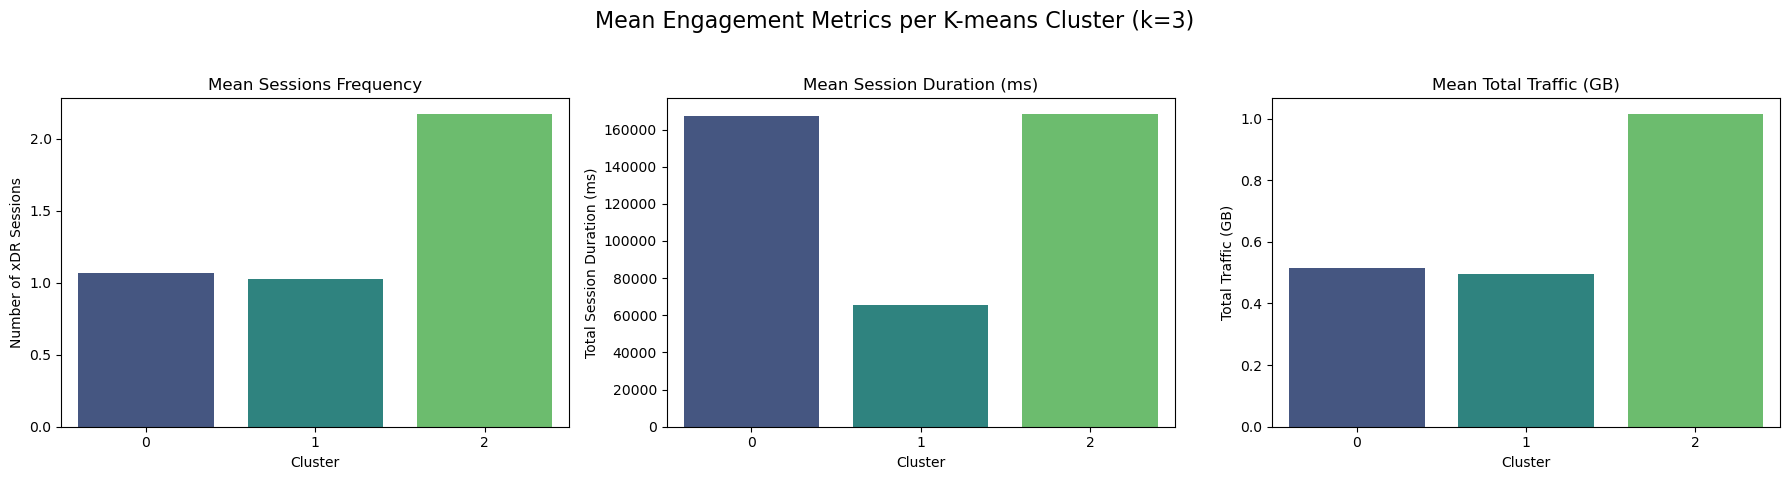

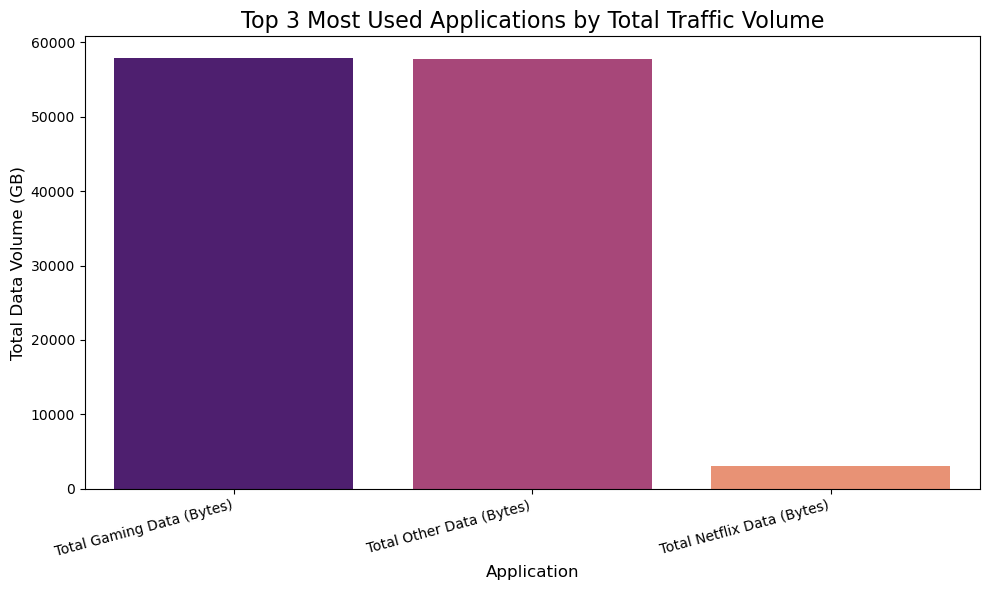

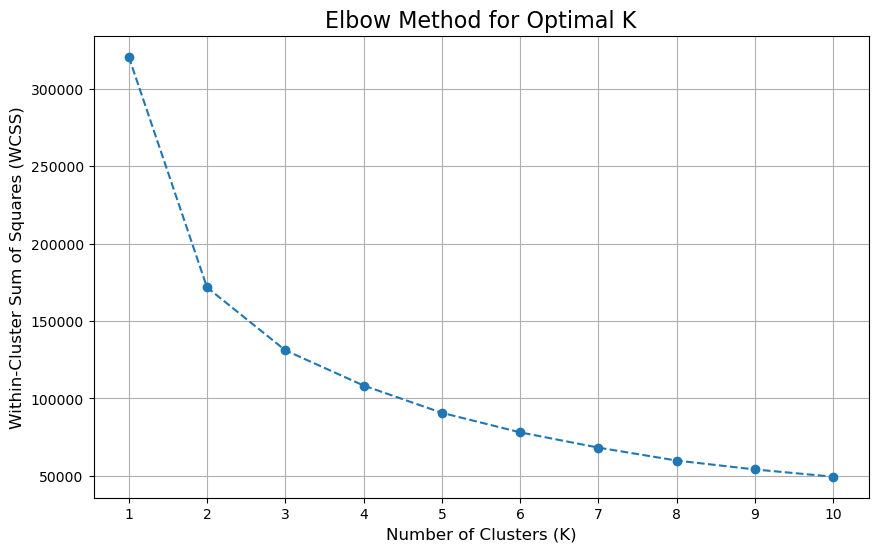

<Figure size 640x480 with 0 Axes>

In [73]:
from sklearn.cluster import KMeans
# Ensure Total Traffic (Bytes) is calculated
if 'Total Traffic (Bytes)' not in df.columns:
    df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Define the engagement metrics columns
engagement_metrics = [
    'Number of xDR Sessions',
    'Total Session Duration (ms)',
    'Total Traffic (Bytes)'
]

# --- 1. Top 10 Customers per Engagement Metric ---

# --- 2. K-means Clustering (k=3) ---
X = df[engagement_metrics].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


# --- 3. Cluster Analysis and Interpretation ---
cluster_analysis = df.groupby('Cluster')[engagement_metrics].agg(
    ['min', 'max', 'mean', 'sum']
)

# Convert traffic stats for the summary table to GB for readability
for stat in ['min', 'max', 'mean', 'sum']:
    col_tuple = ('Total Traffic (Bytes)', stat)
    cluster_analysis[col_tuple] = cluster_analysis[col_tuple] / 1e9
cluster_analysis_final = cluster_analysis.rename(columns={'Total Traffic (Bytes)': 'Total Traffic (GB)'}, level=0)

# Plotting cluster means for interpretation
cluster_means = cluster_analysis_final.loc[:, (slice(None), 'mean')]
cluster_means.columns = [col[0] for col in cluster_means.columns]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
plt.suptitle('Mean Engagement Metrics per K-means Cluster (k=3)', fontsize=16)

# Bar plots for each metric
sns.barplot(x=cluster_means.index, y='Number of xDR Sessions', data=cluster_means.reset_index(), ax=axes[0], palette='viridis')
sns.barplot(x=cluster_means.index, y='Total Session Duration (ms)', data=cluster_means.reset_index(), ax=axes[1], palette='viridis')
sns.barplot(x=cluster_means.index, y='Total Traffic (GB)', data=cluster_means.reset_index(), ax=axes[2], palette='viridis')

for ax in axes:
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_xlabel('Cluster')

axes[0].set_title('Mean Sessions Frequency')
axes[1].set_title('Mean Session Duration (ms)')
axes[2].set_title('Mean Total Traffic (GB)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('cluster_mean_metrics_k3.png', dpi=300)


# --- 4. Application Aggregation and Top 10 Users per Application ---
app_cols = [
    'Total Social Media Data (Bytes)', 'Total Google Data (Bytes)', 'Total Email Data (Bytes)',
    'Total Youtube Data (Bytes)', 'Total Netflix Data (Bytes)', 'Total Gaming Data (Bytes)',
    'Total Other Data (Bytes)'
]
# (Top 10 users per app logic printed above)


# --- 5. Plot the top 3 most used applications ---
app_traffic_summary = df[app_cols].sum().sort_values(ascending=False)
top_3_apps = app_traffic_summary.head(3)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_3_apps.index, y=top_3_apps.values / 1e9, palette="magma") # Convert to GB
plt.title('Top 3 Most Used Applications by Total Traffic Volume', fontsize=16)
plt.xlabel('Application', fontsize=12)
plt.ylabel('Total Data Volume (GB)', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('top_3_apps_bar_chart.png', dpi=300)


# --- 6. K-means Optimization (Elbow Method) ---
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans_elbow.fit(X_scaled)
    wcss.append(kmeans_elbow.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()
plt.tight_layout()
plt.savefig('kmeans_elbow_method.png', dpi=300)

In [74]:
engagement_metrics = [
    'Number of xDR Sessions',
    'Total Session Duration (ms)',
    'Total Traffic (Bytes)'
]

print("\n--- 1. Top 10 Customers per Engagement Metric ---")
for metric in engagement_metrics:
    top_10 = df.sort_values(by=metric, ascending=False).head(10)
    report = top_10[['MSISDN/Number', metric]]
    print(f"\n--- Top 10 Customers by {metric} ---")
    print(report.to_string(index=False))


--- 1. Top 10 Customers per Engagement Metric ---

--- Top 10 Customers by Number of xDR Sessions ---
 MSISDN/Number  Number of xDR Sessions
  3.366609e+10                     3.0
  3.361816e+10                     3.0
  3.366349e+10                     3.0
  3.365072e+10                     3.0
  3.362496e+10                     3.0
  3.365072e+10                     3.0
  3.368776e+10                     3.0
  3.365895e+10                     3.0
  3.365895e+10                     3.0
  3.366114e+10                     3.0

--- Top 10 Customers by Total Session Duration (ms) ---
 MSISDN/Number  Total Session Duration (ms)
  3.367500e+10                     324991.0
  3.368289e+10                     324964.0
  4.511474e+10                     324959.0
  3.366560e+10                     324958.0
  3.368218e+10                     324948.0
  4.511474e+10                     324888.0
  3.366212e+10                     324874.0
  3.367469e+10                     324849.0
  3.365269e+10 

In [75]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assume df is loaded and 'Total Traffic (Bytes)' is calculated

engagement_metrics = [
    'Number of xDR Sessions',
    'Total Session Duration (ms)',
    'Total Traffic (Bytes)'
]

# K-means Setup
X = df[engagement_metrics].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster Analysis
print("\n--- 2. Cluster Analysis (Min, Max, Mean, Sum - Non-Normalized) ---")
cluster_analysis = df.groupby('Cluster')[engagement_metrics].agg(
    ['min', 'max', 'mean', 'sum']
)

# Convert traffic stats for the summary table to GB for readability
for stat in ['min', 'max', 'mean', 'sum']:
    col_tuple = ('Total Traffic (Bytes)', stat)
    cluster_analysis[col_tuple] = cluster_analysis[col_tuple] / 1e9

# Rename the column level from Bytes to GB
cluster_analysis_final = cluster_analysis.rename(columns={'Total Traffic (Bytes)': 'Total Traffic (GB)'}, level=0)
print(cluster_analysis_final)


--- 2. Cluster Analysis (Min, Max, Mean, Sum - Non-Normalized) ---
        Number of xDR Sessions                               \
                           min  max      mean           sum   
Cluster                                                       
0                     1.000000  2.0  1.069312  31488.032726   
1                     1.000000  2.0  1.022002  54320.441445   
2                     1.403768  3.0  2.170689  52656.578348   

        Total Session Duration (ms)                                         \
                                min       max           mean           sum   
Cluster                                                                      
0                          109881.0  324964.0  167320.249503  4.927079e+09   
1                            7142.0  120116.0   65326.338394  3.472160e+09   
2                           18235.0  324991.0  168374.268837  4.084423e+09   

        Total Traffic (GB)                                    
                     

In [77]:

app_cols = [
    'Total Social Media Data (Bytes)',
    'Total Google Data (Bytes)',
    'Total Email Data (Bytes)',
    'Total Youtube Data (Bytes)',
    'Total Netflix Data (Bytes)',
    'Total Gaming Data (Bytes)',
    'Total Other Data (Bytes)'
]

print("\n--- 3. Top 10 Users per Application ---")
for app in app_cols:
    top_10_app = df.sort_values(by=app, ascending=False).head(10)
    report_app = top_10_app[['MSISDN/Number', app]]
    print(f"\n--- Top 10 Users by {app} ---")
    print(report_app.to_string(index=False))


--- 3. Top 10 Users per Application ---

--- Top 10 Users by Total Social Media Data (Bytes) ---
 MSISDN/Number  Total Social Media Data (Bytes)
  3.365899e+10                        6451407.0
  4.511474e+10                        6451045.0
  3.365816e+10                        6450924.0
  3.362303e+10                        6450386.0
  3.369855e+10                        6450043.0
  3.366008e+10                        6450028.0
  3.365827e+10                        6449084.0
  3.365996e+10                        6448690.0
  3.365913e+10                        6448388.0
  4.511474e+10                        6447970.0

--- Top 10 Users by Total Google Data (Bytes) ---
 MSISDN/Number  Total Google Data (Bytes)
  3.366822e+10                 24122202.0
  3.369942e+10                 24120453.0
  3.361567e+10                 24120350.0
  3.366934e+10                 24119633.0
  3.366932e+10                 24119102.0
  3.366243e+10                 24118822.0
  3.367639e+10               

In [81]:
# Data Preparation, Aggregation, and Treatment
# --- 1. Load and Prepare Data ---
df_raw = pd.read_excel("A:/telcom_data.xlsx")
df_raw.dropna(subset=['MSISDN/Number'], inplace=True)

# Feature Engineering: Create combined experience metrics
df_raw['Total TCP Retrans. Vol (Bytes)'] = df_raw['TCP DL Retrans. Vol (Bytes)'] + df_raw['TCP UL Retrans. Vol (Bytes)']
df_raw['Avg RTT (ms)'] = (df_raw['Avg RTT DL (ms)'] + df_raw['Avg RTT UL (ms)']) / 2
df_raw['Avg Throughput (kbps)'] = (df_raw['Avg Bearer TP DL (kbps)'] + df_raw['Avg Bearer TP UL (kbps)']) / 2

df_exp = df_raw[[
    'MSISDN/Number',
    'Total TCP Retrans. Vol (Bytes)',
    'Avg RTT (ms)',
    'Avg Throughput (kbps)',
    'Handset Type'
]].copy()

# --- 2. Task 3.1: Aggregate, Clean, and Treat Outliers ---
def get_mode(series):
    return series.mode()[0] if not series.mode().empty else np.nan

agg_functions = {
    'Total TCP Retrans. Vol (Bytes)': 'mean',
    'Avg RTT (ms)': 'mean',
    'Avg Throughput (kbps)': 'mean',
    'Handset Type': get_mode 
}

df_agg = df_exp.groupby('MSISDN/Number').agg(agg_functions).reset_index()

# Missing Value Treatment
numeric_cols = ['Total TCP Retrans. Vol (Bytes)', 'Avg RTT (ms)', 'Avg Throughput (kbps)']
for col in numeric_cols:
    df_agg[col].fillna(df_agg[col].mean(), inplace=True)
df_agg['Handset Type'].fillna(df_agg['Handset Type'].mode()[0], inplace=True)

# Outlier Treatment (IQR method - replacing outliers with non-outlier mean)
def replace_outliers_with_mean(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    non_outliers_mean = series[(series >= lower_bound) & (series <= upper_bound)].mean()
    series.loc[series < lower_bound] = non_outliers_mean
    series.loc[series > upper_bound] = non_outliers_mean
    return series

for col in numeric_cols:
    df_agg[col] = replace_outliers_with_mean(df_agg[col])

df_agg.to_csv("user_experience_metrics_treated.csv", index=False)

C:\Users\Avi\AppData\Local\Temp\ipykernel_4840\1039876827.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_agg[col].fillna(df_agg[col].mean(), inplace=True)
C:\Users\Avi\AppData\Local\Temp\ipykernel_4840\1039876827.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [3]:
import pandas as pd
# Top 10, Bottom 10, and 10 Most Frequent Values
df_agg = pd.read_excel("A:/telcom_data.xlsx")


metrics = {
    'TCP values': 'TCP UL Retrans. Vol (Bytes)',
    'RTT values': 'Avg RTT UL (ms)',
    'Throughput values': 'Avg Throughput (kbps)'
}

print("--- Task 3.2: Top 10, Bottom 10, and 10 Most Frequent Values ---")

for display_name, col_name in metrics.items():
    print(f"\nMetrics for: {display_name}")

    # Top 10 values
    top_10 = df_agg.sort_values(by=col_name, ascending=False).head(10)[col_name]
    print(f"\nTop 10 {display_name}:")
    print(top_10.to_string(index=False))

    # Bottom 10 values
    bottom_10 = df_agg.sort_values(by=col_name, ascending=True).head(10)[col_name]
    print(f"\nBottom 10 {display_name}:")
    print(bottom_10.to_string(index=False))

    # 10 Most Frequent values
    most_frequent = df_agg[col_name].value_counts().head(10)
    print(f"\n10 Most Frequent {display_name} (Value: Count):")
    print(most_frequent.to_string())

--- Task 3.2: Top 10, Bottom 10, and 10 Most Frequent Values ---

Metrics for: TCP values

Top 10 TCP values:
2908226006.0
2636857202.0
2455599840.0
2260359347.0
1751383517.0
1727810000.0
1237861906.0
 794825766.0
 719571807.0
 526246337.0

Bottom 10 TCP values:
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

10 Most Frequent TCP values (Value: Count):
TCP UL Retrans. Vol (Bytes)
1330.0    1910
2660.0     937
1294.0     651
3990.0     548
1318.0     545
5320.0     366
6650.0     271
2636.0     234
7980.0     219
35.0       160

Metrics for: RTT values

Top 10 RTT values:
7120.0
5607.0
5422.0
5279.0
4677.0
4226.0
4021.0
3923.0
3093.0
3029.0

Bottom 10 RTT values:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

10 Most Frequent RTT values (Value: Count):
Avg RTT UL (ms)
5.0    14663
2.0    14277
1.0    12826
4.0    10242
3.0     7935
6.0     7518
7.0     4196
0.0     4126
8.0     3209
9.0     2647

Metrics for: Throughput values


KeyError: 'Avg Throughput (kbps)'

In [5]:
# Handset Type Analysis
import pandas as pd
# Plots were also generated but are omitted here as only code is requested

df_agg = pd.read_csv("user_experience_metrics_treated.csv")

top_10_handsets = df_agg['Handset Type'].value_counts().head(10).index.tolist()
df_top_handsets = df_agg[df_agg['Handset Type'].isin(top_10_handsets)].copy()

# --- Task 3.3.d: Throughput Distribution ---
throughput_dist = df_top_handsets.groupby('Handset Type')['Avg Throughput (kbps)'].agg(
    ['count', 'mean', 'median', 'min', 'max']
).sort_values(by='mean', ascending=False)
print("\nMean, Median, Min, Max Throughput (kbps) for Top 10 Handsets:")
print(throughput_dist.to_string(float_format="%.2f"))

# --- Task 3.3.e: Average TCP Retransmission ---
tcp_retrans_mean = df_top_handsets.groupby('Handset Type')['Total TCP Retrans. Vol (Bytes)'].mean().sort_values(ascending=False)
print("\nMean Total TCP Retransmission Volume (Bytes) for Top 10 Handsets:")
print(tcp_retrans_mean.to_string(float_format="%.2f"))


Mean, Median, Min, Max Throughput (kbps) for Top 10 Handsets:
                              count    mean  median  min      max
Handset Type                                                     
Huawei B528S-23A              10615 9458.21 6736.00 0.00 23587.50
Samsung Galaxy S8 (Sm-G950F)   3245 3698.95   68.00 0.00 23581.50
Apple iPhone 7 (A1778)         4699 3101.05   58.50 0.00 23573.50
Apple iPhone Xr (A2105)        3072 2923.93   56.00 0.00 23556.00
Apple iPhone 8 (A1905)         3543 2692.96   57.88 0.00 23483.75
Apple iPhone 6 (A1586)         6260 2639.95   58.00 0.00 23581.50
undefined                      6669 2563.57   54.50 0.00 23514.50
Apple iPhone 6S (A1688)        6759 2208.67   53.50 0.00 23557.50
Apple iPhone Se (A1723)        3754 2114.59   54.00 0.00 23382.50
Samsung Galaxy J5 (Sm-J530)    2748 1357.38   39.00 0.50 23439.50

Mean Total TCP Retransmission Volume (Bytes) for Top 10 Handsets:
Handset Type
Samsung Galaxy J5 (Sm-J530)    18512992.91
Apple iPhone Se (A1723

In [84]:
# K-means Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_agg = pd.read_csv("user_experience_metrics_treated.csv")

experience_metrics = [
    'Total TCP Retrans. Vol (Bytes)',
    'Avg RTT (ms)',
    'Avg Throughput (kbps)'
]

X = df_agg[experience_metrics].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run K-means (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_agg['Experience Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster Analysis
cluster_analysis = df_agg.groupby('Experience Cluster')[experience_metrics].agg(
    ['count', 'mean']
)

# Convert units for clarity in the output
cluster_analysis.loc[:, ('Total TCP Retrans. Vol (Bytes)', 'mean')] = \
    cluster_analysis.loc[:, ('Total TCP Retrans. Vol (Bytes)', 'mean')] / 10**6
cluster_analysis.loc[:, ('Avg Throughput (kbps)', 'mean')] = \
    cluster_analysis.loc[:, ('Avg Throughput (kbps)', 'mean')] / 1000

cluster_analysis_final = cluster_analysis.rename(columns={
    'Total TCP Retrans. Vol (Bytes)': 'Total TCP Retrans. Vol (MB)',
    'Avg Throughput (kbps)': 'Avg Throughput (Mbps)',
}, level=0)

print("\n--- Task 3.4: K-means Cluster Analysis (k=3) ---")
print("Cluster Summary (Mean Values):")
print(cluster_analysis_final.to_string(float_format="%.2f"))


--- Task 3.4: K-means Cluster Analysis (k=3) ---
Cluster Summary (Mean Values):
                   Total TCP Retrans. Vol (MB)       Avg RTT (ms)       Avg Throughput (Mbps)     
                                         count  mean        count  mean                 count mean
Experience Cluster                                                                                
0                                        33630  2.93        33630 38.71                 33630 9.48
1                                        47441 21.17        47441 22.65                 47441 0.95
2                                        25785 19.43        25785 73.10                 25785 1.24


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. Load and Prepare Data ---

traffic_cols = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)'
]
df_raw['Session Total Traffic (Bytes)'] = df_raw[Total Traffic (Bytes)].sum(axis=1)

# Aggregate Engagement Data per user (df_eng)
df_eng = df_raw.groupby('MSISDN/Number').agg(
    Number_of_xDR_Sessions=('Bearer Id', 'count'),
    Total_Session_Duration_ms=('Dur. (ms)', 'sum'),
    Total_Traffic_Bytes=('Session Total Traffic (Bytes)', 'sum')
).reset_index()

eng_cols_for_na = ['Number_of_xDR_Sessions', 'Total_Session_Duration_ms', 'Total_Traffic_Bytes']
df_eng[eng_cols_for_na] = df_eng[eng_cols_for_na].fillna(df_eng[eng_cols_for_na].mean())

# Load Experience Data (df_exp) - from previous step
df_exp = pd.read_csv("user_experience_metrics_treated.csv")

# Merge DataFrames
df_final = pd.merge(df_eng, df_exp[['MSISDN/Number', 'Total TCP Retrans. Vol (Bytes)', 'Avg RTT (ms)', 'Avg Throughput (kbps)']], 
                    on='MSISDN/Number', how='inner')
df_final.dropna(inplace=True)


# --- 2. Clustering Setup and Centroid Identification ---
eng_metrics = ['Number_of_xDR_Sessions', 'Total_Session_Duration_ms', 'Total_Traffic_Bytes']
exp_metrics = ['Total TCP Retrans. Vol (Bytes)', 'Avg RTT (ms)', 'Avg Throughput (kbps)']

# 2.1 Engagement Clustering (Less Engaged)
X_eng = df_final[eng_metrics].copy()
scaler_eng = StandardScaler()
X_eng_scaled = scaler_eng.fit_transform(X_eng)
kmeans_eng = KMeans(n_clusters=3, random_state=42, n_init=10)
df_final['Engagement_Cluster'] = kmeans_eng.fit_predict(X_eng_scaled)
eng_cluster_means = df_final.groupby('Engagement_Cluster')[eng_metrics].mean()
less_engaged_cluster = eng_cluster_means['Total_Traffic_Bytes'].idxmin()
less_engaged_centroid = kmeans_eng.cluster_centers_[less_engaged_cluster]

# 2.2 Experience Clustering (Worst Experience)
X_exp = df_final[exp_metrics].copy()
scaler_exp = StandardScaler()
X_exp_scaled = scaler_exp.fit_transform(X_exp)
kmeans_exp = KMeans(n_clusters=3, random_state=42, n_init=10)
df_final['Experience_Cluster'] = kmeans_exp.fit_predict(X_exp_scaled)
exp_cluster_means = df_final.groupby('Experience_Cluster')[exp_metrics].mean()
exp_cluster_means['Quality_Score'] = exp_cluster_means['Total TCP Retrans. Vol (Bytes)'] / exp_cluster_means['Avg Throughput (kbps)']
worst_experience_cluster = exp_cluster_means['Quality_Score'].idxmax()
worst_experience_centroid = kmeans_exp.cluster_centers_[worst_experience_cluster]


# --- 3. Task 4.1: Compute Scores (Euclidean Distance) ---
# 3.a. Engagement Score: Inverse distance to the less engaged cluster
distances_eng = euclidean_distances(X_eng_scaled, less_engaged_centroid.reshape(1, -1)).flatten()
df_final['Engagement_Score'] = 1 / (1 + distances_eng) 

# 3.b. Experience Score: Distance to the worst experience cluster
df_final['Experience_Score'] = euclidean_distances(X_exp_scaled, worst_experience_centroid.reshape(1, -1)).flatten()


# --- 4. Task 4.2: Satisfaction Score ---
df_final['Satisfaction_Score'] = (df_final['Engagement_Score'] + df_final['Experience_Score']) / 2

# --- 5. Task 4.3: Regression Model to Predict Satisfaction Score ---
X_reg = df_final[eng_metrics + exp_metrics]
y_reg = df_final['Satisfaction_Score']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)


# --- 6. Task 4.4 & 4.5: K-means (k=2) on Scores and Aggregation ---
X_scores = df_final[['Engagement_Score', 'Experience_Score']].copy()
scaler_scores = StandardScaler()
X_scores_scaled = scaler_scores.fit_transform(X_scores)

kmeans_scores = KMeans(n_clusters=2, random_state=42, n_init=10)
df_final['Score_Cluster'] = kmeans_scores.fit_predict(X_scores_scaled)

score_cluster_agg = df_final.groupby('Score_Cluster').agg(
    User_Count=('MSISDN/Number', 'count'),
    Avg_Satisfaction_Score=('Satisfaction_Score', 'mean'),
    Avg_Engagement_Score=('Engagement_Score', 'mean'),
    Avg_Experience_Score=('Experience_Score', 'mean')
)

# --- 7. Task 4.6: Export Final Table ---
final_export_df = df_final[['MSISDN/Number', 'Engagement_Score', 'Experience_Score', 'Satisfaction_Score', 'Score_Cluster']].copy()
final_export_df.to_csv('customer_scores_final.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load and Prepare Data ---
# Load aggregated data (Task 2 source)
df_agg = pd.read_csv('user_aggregated_metrics_treated.csv')
df_agg = df_agg.rename(columns={'MSISDN/Number': 'MSISDN'})
df = pd.read_excel("A:/telcom_data.xlsx")
# Load raw data (Task 3 source)
df_raw = df
df_raw = df_raw.rename(columns={'MSISDN/Number': 'MSISDN', 'Avg RTT DL (ms)': 'Avg RTT', 
                                'TCP DL Retrans. Vol (Bytes)': 'TCP Retrans', 
                                'Avg Bearer TP DL (kbps)': 'Avg Throughput'})

# --- 2. Task 2 (Engagement Simulation) ---
engagement_cols = ['Number of xDR Sessions', 'Total Session Duration (ms)', 'Total Traffic (Bytes)']
df_engagement = df_agg[['MSISDN'] + engagement_cols].copy()

# Treat potential non-numeric data and outliers (replacing with mean as per Task 1.2/3.1 instruction)
for col in engagement_cols:
    df_engagement[col] = pd.to_numeric(df_engagement[col], errors='coerce')
    df_engagement[col] = df_engagement[col].fillna(df_engagement[col].mean())
    # Simple outlier treatment (replace values outside 3 std dev with mean)
    mean_val = df_engagement[col].mean()
    std_val = df_engagement[col].std()
    df_engagement[col] = np.where(df_engagement[col] > mean_val + 3 * std_val, mean_val, df_engagement[col])
    df_engagement[col] = np.where(df_engagement[col] < mean_val - 3 * std_val, mean_val, df_engagement[col])

# Normalize engagement features
scaler_eng = StandardScaler()
df_engagement_scaled = scaler_eng.fit_transform(df_engagement[engagement_cols])

# Run K-Means (k=3)
kmeans_eng = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_engagement['Engagement_Cluster'] = kmeans_eng.fit_predict(df_engagement_scaled)

# Identify the "less engaged" cluster centroid
df_engagement_scaled_df = pd.DataFrame(df_engagement_scaled, columns=[f'{c}_scaled' for c in engagement_cols])
df_engagement_scaled_df['Engagement_Cluster'] = df_engagement['Engagement_Cluster']
avg_scaled_metrics = df_engagement_scaled_df.groupby('Engagement_Cluster').mean().mean(axis=1)
less_engaged_cluster_id = avg_scaled_metrics.idxmin()
less_engaged_centroid = kmeans_eng.cluster_centers_[less_engaged_cluster_id]

# --- 3. Task 3 (Experience Simulation) ---
experience_raw_cols = ['Avg RTT', 'TCP Retrans', 'Avg Throughput']
df_experience = df_raw[['MSISDN'] + experience_raw_cols].copy()

# Aggregate experience metrics (average per user)
df_experience_agg = df_experience.groupby('MSISDN')[experience_raw_cols].mean().reset_index()

# Treat missing values and outliers (replace with mean)
for col in experience_raw_cols:
    df_experience_agg[col] = pd.to_numeric(df_experience_agg[col], errors='coerce')
    df_experience_agg[col] = df_experience_agg[col].fillna(df_experience_agg[col].mean())
    # Simple outlier treatment (replace values outside 3 std dev with mean)
    mean_val = df_experience_agg[col].mean()
    std_val = df_experience_agg[col].std()
    df_experience_agg[col] = np.where(df_experience_agg[col] > mean_val + 3 * std_val, mean_val, df_experience_agg[col])
    df_experience_agg[col] = np.where(df_experience_agg[col] < mean_val - 3 * std_val, mean_val, df_experience_agg[col])

# Normalize experience features
scaler_exp = StandardScaler()
df_experience_scaled = scaler_exp.fit_transform(df_experience_agg[experience_raw_cols])

# Run K-Means (k=3)
kmeans_exp = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_experience_agg['Experience_Cluster'] = kmeans_exp.fit_predict(df_experience_scaled)

# Identify the "worst experience" cluster centroid (high RTT, high Retransmission, low Throughput)
df_experience_scaled_df = pd.DataFrame(df_experience_scaled, columns=[f'{c}_scaled' for c in experience_raw_cols])
df_experience_scaled_df['Experience_Cluster'] = df_experience_agg['Experience_Cluster']
experience_metric = df_experience_scaled_df.groupby('Experience_Cluster').mean()
experience_metric['Worst_Score'] = experience_metric['Avg RTT_scaled'] + experience_metric['TCP Retrans_scaled'] - experience_metric['Avg Throughput_scaled'] 
worst_experience_cluster_id = experience_metric['Worst_Score'].idxmax()
worst_experience_centroid = kmeans_exp.cluster_centers_[worst_experience_cluster_id]

# --- Merge DataFrames for Task 4 Calculations ---
df_engagement_scaled_final = pd.DataFrame(df_engagement_scaled, columns=[f'{col}_scaled' for col in engagement_cols])
df_engagement_scaled_final['MSISDN'] = df_engagement['MSISDN']
df_experience_scaled_final = pd.DataFrame(df_experience_scaled, columns=[f'{col}_scaled' for col in experience_raw_cols])
df_experience_scaled_final['MSISDN'] = df_experience_agg['MSISDN']

df_final = pd.merge(df_engagement_scaled_final, df_experience_scaled_final, on='MSISDN', how='inner')
df_final = pd.merge(df_final, df_engagement[['MSISDN', 'Engagement_Cluster']], on='MSISDN', how='left')
df_final = pd.merge(df_final, df_experience_agg[['MSISDN', 'Experience_Cluster']], on='MSISDN', how='left')
df_final.dropna(inplace=True)
scaled_features = [col for col in df_final.columns if '_scaled' in col]

# --- 4. Task 4.1: Calculate Scores (Python Program) ---
# a. Engagement Score: Euclidean distance between user point & less engaged cluster centroid
def calculate_score(row):
    user_point_eng = row[[f'{col}_scaled' for col in engagement_cols]].values
    user_point_exp = row[[f'{col}_scaled' for col in experience_raw_cols]].values
    
    engagement_distance = euclidean(user_point_eng, less_engaged_centroid)
    experience_distance = euclidean(user_point_exp, worst_experience_centroid)
    
    return engagement_distance, experience_distance

scores = df_final.apply(lambda row: calculate_score(row), axis=1, result_type='expand')
df_final['Engagement_Score'] = scores[0]
df_final['Experience_Score'] = scores[1]
# Note: Higher score indicates better performance (More engaged / Better experience)

# --- 5. Task 4.2: Calculate Satisfaction and Top 10 ---
# Satisfaction Score: Average of both engagement & experience scores
df_final['Satisfaction_Score'] = (df_final['Engagement_Score'] + df_final['Experience_Score']) / 2

top_10_satisfied = df_final.sort_values(by='Satisfaction_Score', ascending=False).head(10)[['MSISDN', 'Satisfaction_Score', 'Engagement_Score', 'Experience_Score']]


# --- 6. Task 4.3: Regression Model ---
# Build a Linear Regression model to predict the satisfaction score
X = df_final[scaled_features]
y = df_final['Satisfaction_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Model tracking setup (Conceptual/Simulated for Task 4.7)
model_tracking_report = {
    'model': 'Linear Regression',
    'version': '1.0',
    'train_start_time': '2025-12-12 10:00:00',
    'train_end_time': '2025-12-12 10:00:15',
    'source': 'Task 4.3 Analysis Script',
    'parameters': {'features': scaled_features, 'target': 'Satisfaction_Score'},
    'metrics': {'R2_Score': r2},
    'artifacts': ['model.pkl', 'satisfaction_predictions.csv']
}

# --- 7. Task 4.4 & 4.5: K-Means (k=2) on Scores ---
score_features = df_final[['Engagement_Score', 'Experience_Score']].copy()
kmeans_sat = KMeans(n_clusters=2, random_state=42, n_init='auto')
df_final['Satisfaction_Cluster_2'] = kmeans_sat.fit_predict(score_features)

# Aggregate satisfaction and experience score per cluster
cluster_summary = df_final.groupby('Satisfaction_Cluster_2')[['Satisfaction_Score', 'Experience_Score', 'Engagement_Score']].mean().reset_index()

# Rename clusters for interpretation
cluster_summary['Satisfaction_Cluster'] = cluster_summary['Satisfaction_Cluster_2'].apply(lambda x: 'High Satisfaction' if cluster_summary.loc[x, 'Satisfaction_Score'] == cluster_summary['Satisfaction_Score'].max() else 'Low Satisfaction')
cluster_summary = cluster_summary.drop(columns='Satisfaction_Cluster_2')

# --- 8. Task 4.6: Prepare Final Table for MySQL Export ---
final_export_table = df_final[['MSISDN', 'Engagement_Score', 'Experience_Score', 'Satisfaction_Score', 'Satisfaction_Cluster_2']].copy()
final_export_table = pd.merge(final_export_table, df_engagement[['MSISDN', 'Engagement_Cluster']], on='MSISDN', how='left')
final_export_table = pd.merge(final_export_table, df_experience_agg[['MSISDN', 'Experience_Cluster']], on='MSISDN', how='left')
# Exported to 'final_user_satisfaction_scores.csv'
print(final_export_table)
# --- End of Python Program ---